In [1]:
from gorgo import infer, condition, draw_from, keep_deterministic
from gorgo.distributions.builtin_dists import Gaussian, Beta, Uniform, Gamma, Categorical, Binomial

import numpy as np; np.random.seed(42)
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# Threshold adjustment model
This model infers a population property (e.g., Zarpie mean height) from three things:
* an observed sample (e.g., observed Zarpies)
* **a model of selection bias** (e.g., how Zarpies board the boat), including:
    * *selection threshold* (e.g., boat height)
    * *selection probability past threshold* (e.g., boarding probability if taller than boat)
* a prior on what the population is like (e.g., normal distribution with uncertainty over the mean height). 

Terms in equations:
* $z$ = set of heights of observed Zarpies, $z_i$ = height of an observed Zarpie

$$z=\{4, 5, 6, 6, 7, 8\}$$

* $t$ = boat height (threshold)

$$t \in \{6, 7, 8, 9, 10\}$$

* $\epsilon$ = pass-through probability if taller than boat height (filter strength)

$$\epsilon = 0.1$$

* $P(\mu)$ = **prior**, $\mu$ = prior on mean Zarpie height[^1]

$$\mu \sim \mathcal{N}(10, 5)$$

<div class="alert alert-block alert-info">
Although this conceptual model uses a continuous normal distribution as the prior, we implement the prior as a discrete distribution in our code for ease of inference. 
</div>

* $P(z|t, \epsilon, \mu)$ = **likelihood** of observing Zarpie $z$ given population with mean $\mu$ and SD $\sigma = 2$

$$P(z) \sim \mathcal{N}(\mu, 2)$$

    

**Threshold adjustment model** (equation 1):

$$P(\mu|z, t, \epsilon) \propto P(z|t, \epsilon, \mu) P(\mu)$$

<!-- with normalizing factor:
$$P(\mu|z, t, \epsilon) = \frac{P(z|t, \epsilon, \mu) P(\mu)}{\int P(Z|t, \epsilon, \mu')P(\mu') d\mu'}$$
-->

where $P(z|t, \epsilon, \mu) = \prod_{i} P(z_i|t, \epsilon, \mu)$, assuming each Zarpie $z_i$ is an independent observation

Boat boarding model (**likelihood**) (equation 2):

$$P(z_i|t, \epsilon, \mu) = \mathcal{N}(z_i|\mu, \sigma) f(z_i|t, \epsilon)$$

Boat boarding **filter function** (logistic function):
$$f(z_i|t, \epsilon)=\epsilon + \frac{1-\epsilon}{1+e^{-k(t-z_i)}}$$

<!-- step function
\begin{equation}
  P(z|t, \epsilon)=\begin{cases}
    1, & \text{if $z < t$}.\\
    \epsilon, & \text{otherwise}.
  \end{cases}
\end{equation}
-->

<div class="alert alert-block alert-info">
Adjustment still occurs whether the filter function is a logistic vs step function, but see below for differences.
</div>


In [2]:
# prior on Zarpie mean height
# = a normal distribution, limited to range mean-20 to mean+20
@keep_deterministic
def discretized_gaussian(mean, sd, support=None):
    if support is None:
        support = list(np.arange(-20+mean, 20+mean, step=.25)) # step needs to be 1, .5, or .25
    return Categorical.from_continuous(
        Gaussian(mean, sd),
        support=support # restrict range to make inference easier
    )

# logistic filter
# k is 0 to infinity, as k approaches inf, filter becomes a step-function
def logistic_filter(zarpie_height, boat_height, pass_prob, k):
    boarding_prob = np.float64(pass_prob + (1 - pass_prob)/(1 + np.e**(-k*(boat_height - zarpie_height))))
    return boarding_prob

# boat boarding model
# requires: boat height, population mean, pass-through probability
@infer
def boat_boarding_model(boat_height, pop_mean, pass_prob, k):
    zarpie_height = discretized_gaussian(pop_mean, 2).sample() # randomly sample Zarpies from prior (Gaussian with mean _, SD 2)
    # step-function filter
    # condition(1 if zarpie_height < boat_height # if Zarpie shorter than boat height, board
    #           else pass_prob) # if Zarpie taller than boat height, board based on pass-through probability
    boarding_prob = logistic_filter(zarpie_height, boat_height, pass_prob, k) # logistic filter
    condition(boarding_prob)
    return zarpie_height

# infer population mean
# requires: boat height, observed Zarpie heights
# assume: prior as Gaussian with mean drawn from (10, 5), pass-through probability .1
@infer
def threshold_adjustment_model(boat_height, zarpie_heights, pop_mean_prior_mean = 10, pop_mean_prior_sd = 5, pass_prob = .1, k = 1):
    pop_mean = discretized_gaussian(pop_mean_prior_mean, pop_mean_prior_sd).sample()  # sample a population mean from prior
    # [
    #     condition(boat_boarding_model(boat_height, pop_mean) == zh)
    #     for zh in zarpie_heights
    # ]
    dist = boat_boarding_model(boat_height, pop_mean, pass_prob, k)  # run boat boarding model with given boat height, population mean, etc.
    [dist.observe(zarpie_height) for zarpie_height in zarpie_heights]
    return pop_mean 


<div class="alert alert-block alert-info">
Inference is required in the boat boarding model to run inference over the filtered population, rather than the prior population. This is a subtle difference between \propto and = in the equations.
</div>

## Exploring the model

### Adjustment: observed sample vs boat height

In [34]:
threshold_adjustment_ev_list = []

for boat_height in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for zarpie_height_mode in [3, 4, 5, 6, 7, 8]: # parameterize mode Zarpie's height
        # run the model
        threshold_adjustment_res = threshold_adjustment_model(
            boat_height = boat_height, 
            zarpie_heights = (zarpie_height_mode - 2, # observed sample, must be integers
                              zarpie_height_mode - 1,
                              zarpie_height_mode,
                              zarpie_height_mode, 
                              zarpie_height_mode + 1,
                              zarpie_height_mode + 2)
            )
        # record the expected value
        threshold_adjustment_ev_list.append(
            {
            "boat_height": boat_height,
            "zarpie_height_mode": zarpie_height_mode,
            "expected_value": threshold_adjustment_res.expected_value()
            })

# convert to df
threshold_adjustment_ev_df = pd.DataFrame(threshold_adjustment_ev_list)

filter_1462ddbc0.py:4: RuntimeWarning: overflow encountered in scalar power
  boarding_prob = pass_prob + (1 - pass_prob) / (1 + np.e ** (-k * (boat_height - zarpie_height)))


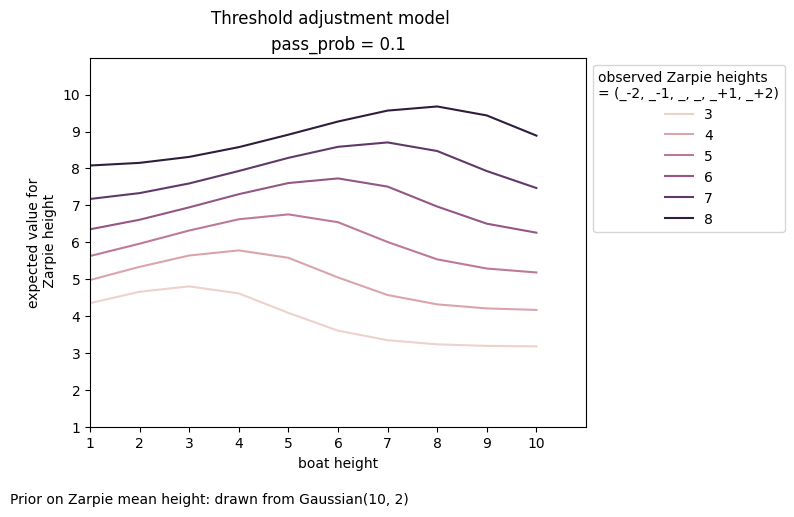

In [35]:
# plot expected value
g = sns.lineplot(data = threshold_adjustment_ev_df,
                 x = "boat_height",
                 y = "expected_value",
                 hue = "zarpie_height_mode")
plt.legend(title = "observed Zarpie heights \n= (_-2, _-1, _, _, _+1, _+2)")
sns.move_legend(g, "upper left", bbox_to_anchor = (1, 1))
plt.ylabel("expected value for\n Zarpie height")
plt.ylim(1, 10+1)
plt.yticks(ticks = list(range(1, 10+1)))
plt.xlabel("boat height")
plt.xlim(1, 10+1)
plt.xticks(ticks = list(range(1, 10+1)))
plt.suptitle("Threshold adjustment model")
plt.title("pass_prob = 0.1")
plt.figtext(x = 0, y = -.05,
            s = "Prior on Zarpie mean height: drawn from Gaussian(10, 2)")

plt.savefig("figs/adjustment_model_ev.png", bbox_inches = "tight")
plt.show(g)

* **Adjustment occurs** (bump) when the observed sample clusters right below the boat height. 
    * For study design, this means our choice of observed sample and boat height is arbitary, we just need to fix one and parameterize the other to capture the bump. 
    * For ecological reasons, we will **fix the observed sample** (4, 5, 6, 6, 7, 8) and **parameterize boat height** (5-9), as a belief in how biasing the structure is. 

### Prior (mean & SD of distribution that prior mean is drawn from)

### Filter strength (pass-through probability)

In [15]:
threshold_adjustment_ev_list = []

for boat_height in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for zarpie_height_mode in [3, 4, 5, 6, 7, 8]: # parameterize mode Zarpie's height
        for pass_prob in [0.1, 0.2, 0.3, 0.4, 0.5]:
            # run the model
            threshold_adjustment_res = threshold_adjustment_model(
                boat_height = boat_height, 
                zarpie_heights = (zarpie_height_mode - 2, # observed sample, must be integers
                                  zarpie_height_mode - 1,
                                  zarpie_height_mode,
                                  zarpie_height_mode, 
                                  zarpie_height_mode + 1,
                                  zarpie_height_mode + 2), 
                pass_prob = pass_prob
            )
            # record the expected value
            threshold_adjustment_ev_list.append(
                {
                "boat_height": boat_height,
                "zarpie_height_mode": zarpie_height_mode,
                "pass_prob": pass_prob,
                "expected_value": threshold_adjustment_res.expected_value()
                })

# convert to df
threshold_adjustment_ev_df = pd.DataFrame(threshold_adjustment_ev_list)

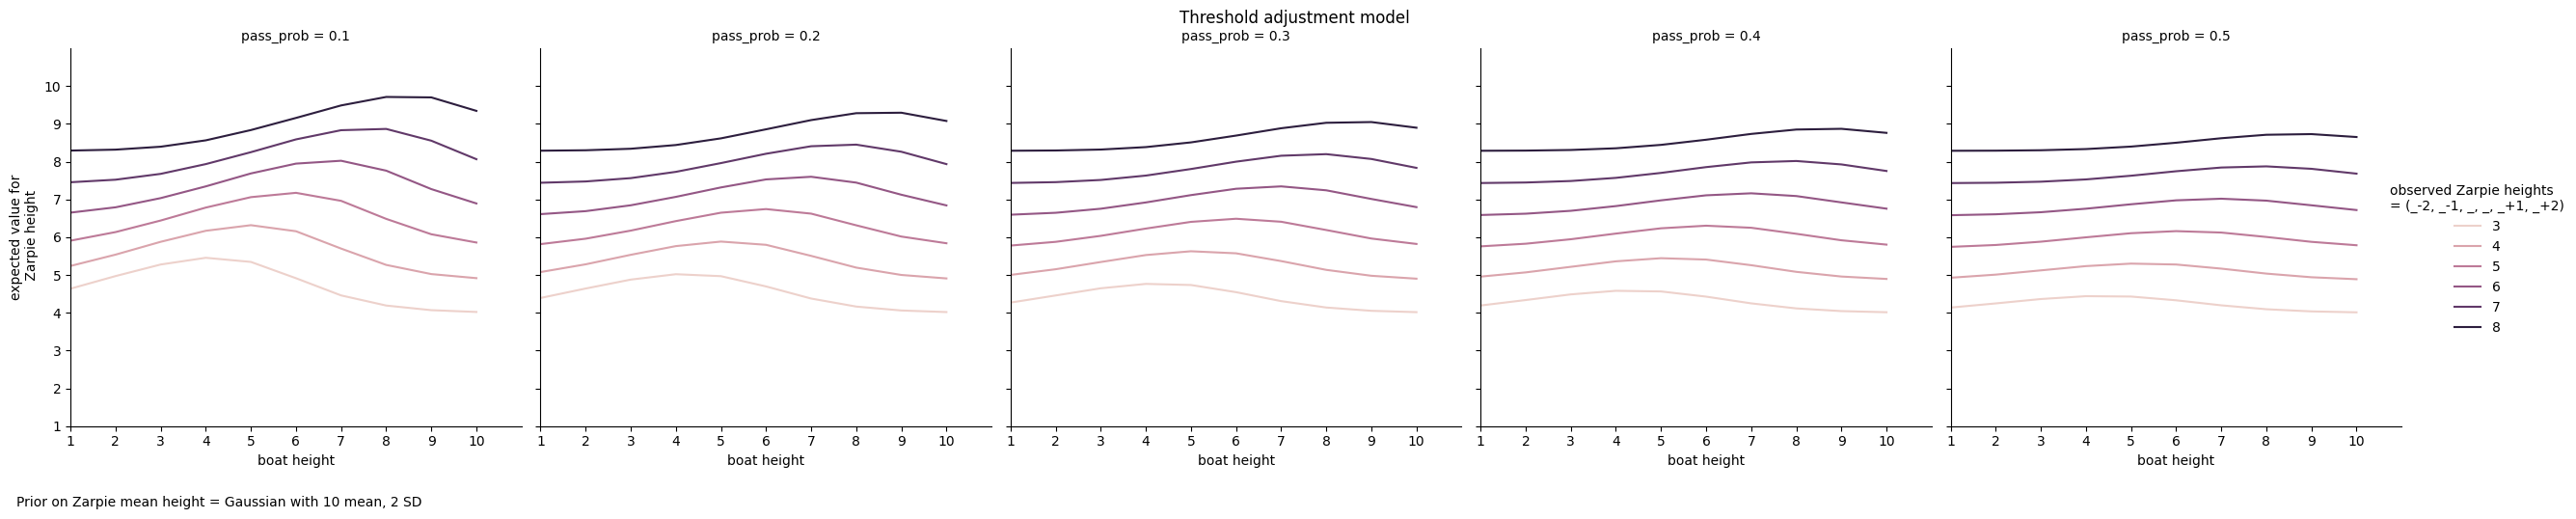

In [108]:
g = sns.relplot(data = threshold_adjustment_ev_df,
                 x = "boat_height",
                 y = "expected_value",
                 hue = "zarpie_height_mode",
                 col = "pass_prob",
                 kind = "line")
g._legend.set_title("observed Zarpie heights \n= (_-2, _-1, _, _, _+1, _+2)")
g.set_ylabels("expected value for\n Zarpie height")
plt.ylim(1, 10+1)
plt.yticks(ticks = list(range(1, 10+1)))
g.set_xlabels("boat height")
plt.xlim(1, 10+1)
plt.xticks(ticks = list(range(1, 10+1)))
g.figure.suptitle("Threshold adjustment model")
g.figure.subplots_adjust(top=0.9)
plt.figtext(x = 0, y = -.05,
            s = "Prior on Zarpie mean height = Gaussian with 10 mean, 2 SD")

plt.savefig("figs/adjustment_model_ev_passprob.png", bbox_inches = "tight")
plt.show(g)

* Greater **pass-through probability** (weaker bias/filter) decreases adjustment, flattening out all lines. 
    * For our study, we will choose a **low pass-through probability** (pass_prob = 0.1) to maximize likelihood of seeing adjustment, and use boat training to train low pass-through probability. 

In [33]:
threshold_adjustment_ev_list = []

for boat_height in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for zarpie_height_mode in [3, 4, 5, 6, 7, 8]: # parameterize mode Zarpie's height
        for pop_mean_prior_mean in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]: # mean of Gaussian from which we draw population mean
            for pop_mean_prior_sd in [1, 2, 3, 4]: # sd of Gaussian from which we draw population mean
                # run the model
                threshold_adjustment_res = threshold_adjustment_model(
                    boat_height = boat_height, 
                    zarpie_heights = (zarpie_height_mode - 2, # observed sample, must be integers
                                        zarpie_height_mode - 1,
                                        zarpie_height_mode,
                                        zarpie_height_mode, 
                                        zarpie_height_mode + 1,
                                        zarpie_height_mode + 2), 
                        pop_mean_prior_mean = pop_mean_prior_mean,
                        pop_mean_prior_sd = pop_mean_prior_sd
                        )
                # record the expected value
                threshold_adjustment_ev_list.append(
                    {
                    "boat_height": boat_height,
                    "zarpie_height_mode": zarpie_height_mode,
                    "pop_mean_prior_mean": pop_mean_prior_mean,
                    "pop_mean_prior_sd": pop_mean_prior_sd,
                    "expected_value": threshold_adjustment_res.expected_value()
                    })

# convert to df
threshold_adjustment_ev_df = pd.DataFrame(threshold_adjustment_ev_list)

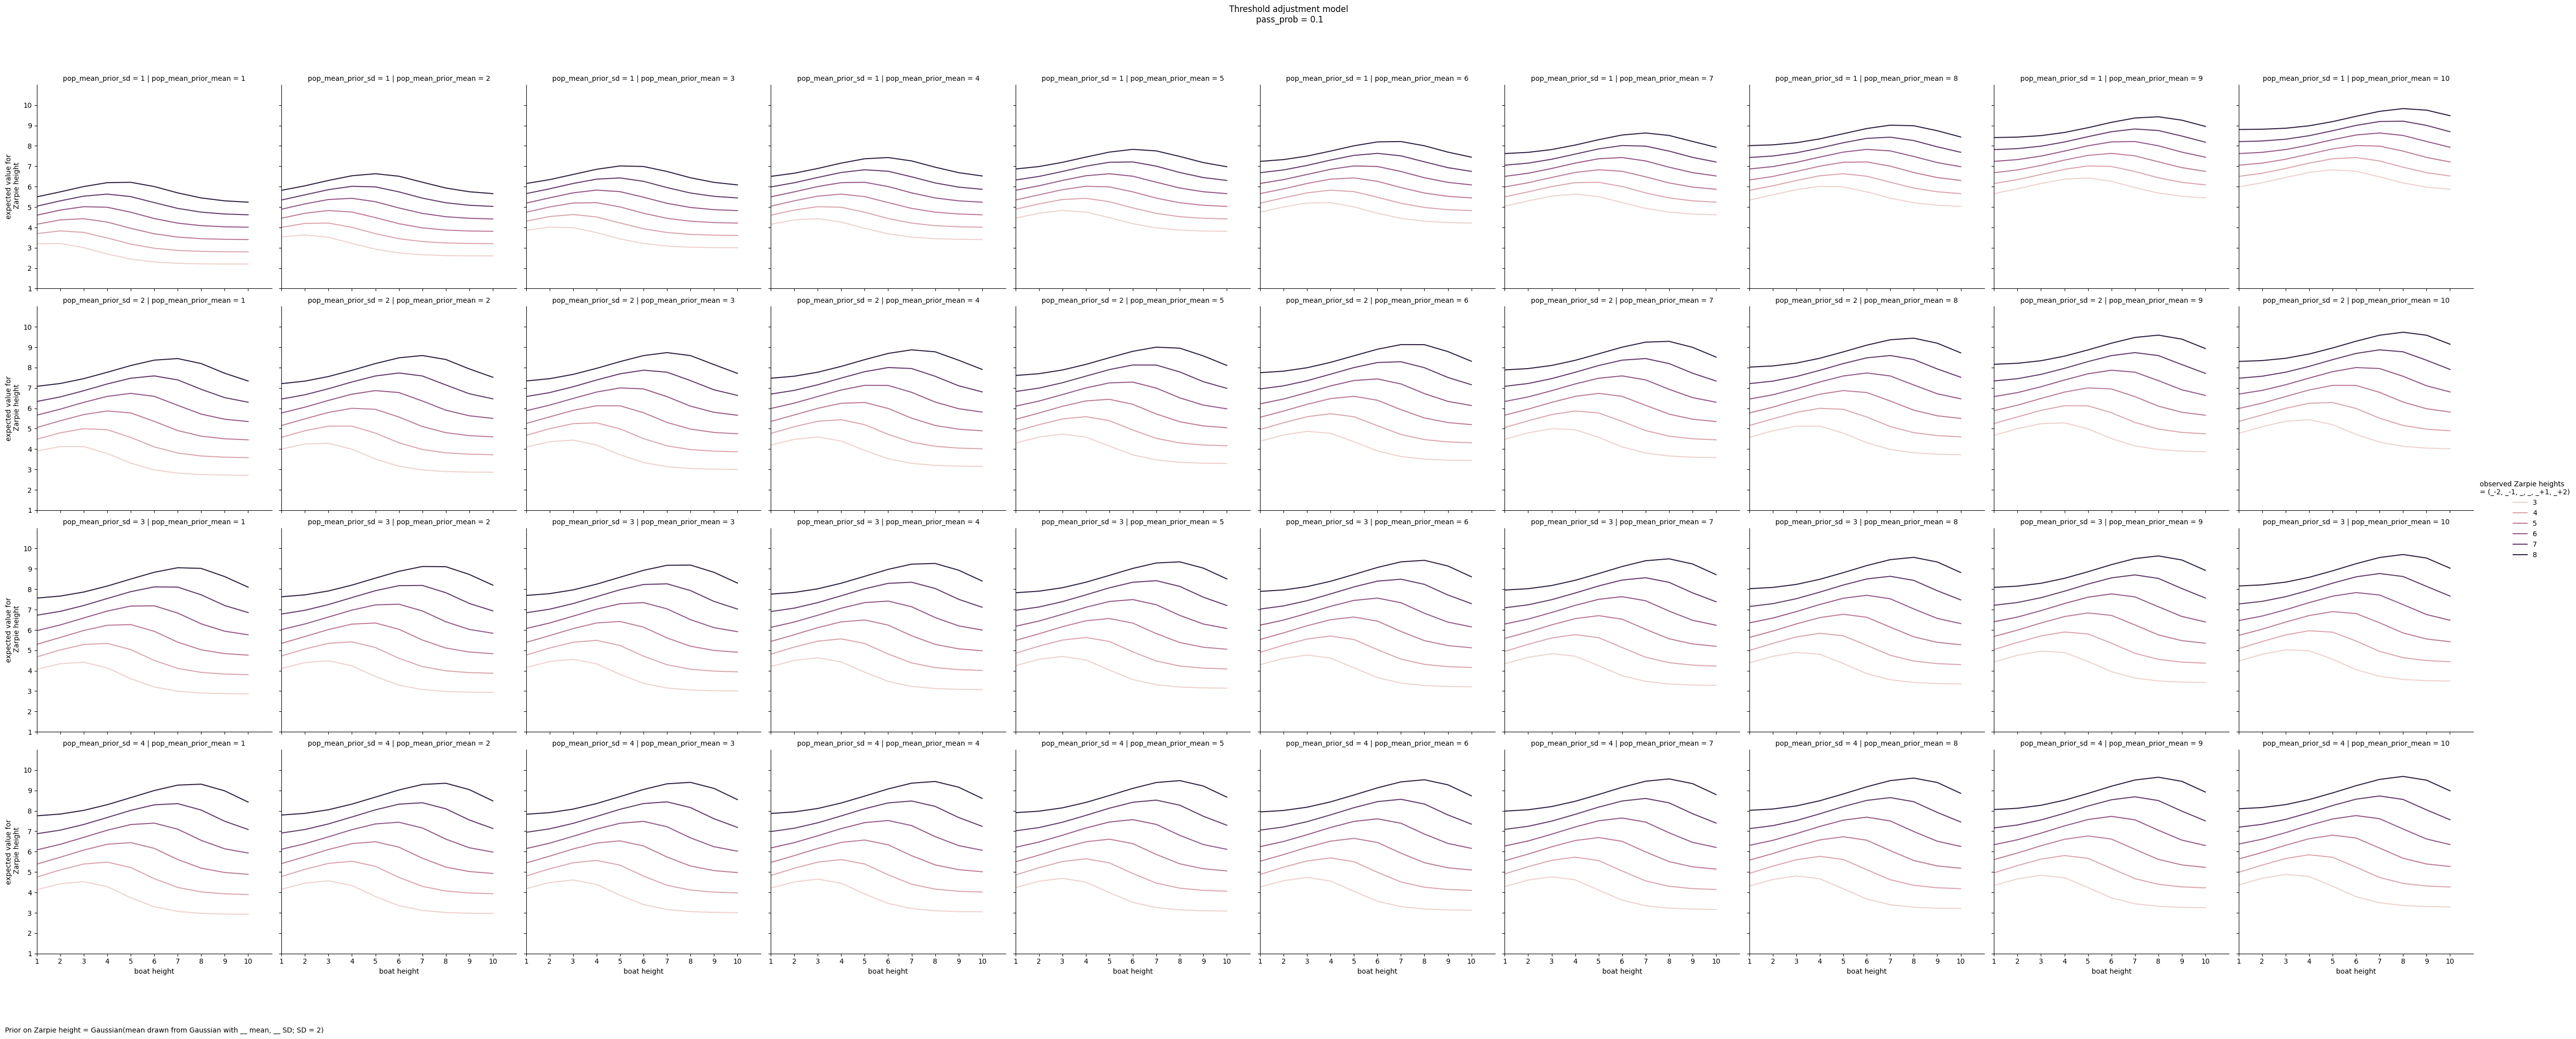

In [34]:
g = sns.relplot(data = threshold_adjustment_ev_df,
                 x = "boat_height",
                 y = "expected_value",
                 hue = "zarpie_height_mode",
                 col = "pop_mean_prior_mean",
                 row = "pop_mean_prior_sd",
                 kind = "line")
g._legend.set_title("observed Zarpie heights \n= (_-2, _-1, _, _, _+1, _+2)")
g.set_ylabels("expected value for\n Zarpie height")
plt.ylim(1, 10+1)
plt.yticks(ticks = list(range(1, 10+1)))
g.set_xlabels("boat height")
plt.xlim(1, 10+1)
plt.xticks(ticks = list(range(1, 10+1)))
g.figure.suptitle("Threshold adjustment model \npass_prob = 0.1")
g.figure.subplots_adjust(top=0.9)
plt.figtext(x = 0, y = -.05,
            s = "Prior on Zarpie height = Gaussian(mean drawn from Gaussian with __ mean, __ SD; SD = 2)")

plt.savefig("figs/adjustment_model_predictions_prior.png", bbox_inches = "tight")
plt.show(g)

* **A prior for taller heights** (prior mean sampled from distribution with higher mean) shifts all inferences to be taller (higher on plot), but does not appear to affect adjustment (height of the bump).
    * For study design, prior mean does not seem to matter to adjustment, so we have **arbitrarily** set it at 10. Prior mean does affect inferences though, which affects DV options. 

* **A less certain prior** (prior mean sampled from distribution with higher SD) appears to magnify adjustment effects (height of the bump when sample clusters just below the threshold). 
    * For study design, ...? 

### Filter steepness

$k$ is a parameter that controls the steepness of the logistic filter. As $k \rightarrow \infty$, the logistic filter becomes stepped. 

$$f(z_i|t, \epsilon)=\epsilon + \frac{1-\epsilon}{1+e^{-k(t-z_i)}}$$


In [24]:
boarding_prob_list = []

# parameterize k
for k in [0.01, 0.1, 0.5, 1, 2, 10, 100]:
    # look at a range of zarpie heights
    for zarpie_height in np.arange(1, 10):
        # run the logistic filter for boat height = 6
        boarding_prob = logistic_filter(zarpie_height = zarpie_height, boat_height = 6, pass_prob = 0.1, k = k)
        boarding_prob_list.append(dict(
            zarpie_height = zarpie_height,
            boat_height = 6,
            pass_prob = 0.1,
            k = k,
            boarding_prob = boarding_prob
        ))
        
# convert to df
boarding_prob_df = pd.DataFrame(boarding_prob_list)

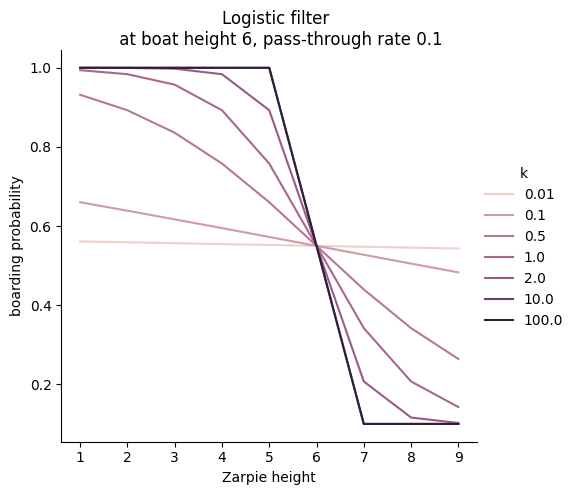

In [26]:
# plot logistic filter with varying k
 
from matplotlib.colors import LogNorm

g = sns.relplot(data = boarding_prob_df,
                 x = "zarpie_height",
                 y = "boarding_prob",
                 hue = "k",
                 hue_norm = LogNorm(),
                 kind = "line",
                 legend = "full")
g.set_ylabels("boarding probability")
g.set_xlabels("Zarpie height")
g.figure.suptitle("Logistic filter \n at boat height 6, pass-through rate 0.1")
g.figure.subplots_adjust(top = 0.9)

plt.savefig("figs/adjustment_model_logistic_filter_k.png", bbox_inches = "tight")
plt.show(g)

In [27]:
boarding_list = []

# parameterize k
for k in [0.01, 0.1, 0.5, 1, 2, 10, 100]:
    # look at a range of zarpie heights
    for zarpie_height in np.arange(1, 10):
        # run the logistic filter for boat height = 6
        boarding_list = boat_boarding_model(boat_height = 6, pop_mean = 10, pass_prob = 0.1, k = k)
        boarding_list.append(dict(
            zarpie_height = zarpie_height,
            boat_height = 6,
            pop_mean = 10,
            pass_prob = 0.1,
            k = k
        ))
        
# convert to df
boarding_df = pd.DataFrame(boarding_list)

AttributeError: 'Categorical' object has no attribute 'append'

In [ ]:
# plot post-boarding distribution (equation 2)

#### Inferences with varying filter steepness

In [17]:
boat_heights = [6, 7, 8, 9, 10]
zarpie_heights = (4, 5, 6, 6, 7, 8) 

threshold_adjustment_res_list = []

# parameterize k
for k in [0.01, 0.1, 0.5, 1, 5, 10]:
    # participants randomly assigned to one of these boat heights
    for boat_height in boat_heights: 
        # run the model
        threshold_adjustment_res = threshold_adjustment_model(
            k = k,
            boat_height = boat_height, 
            pop_mean_prior_mean = 10, # set by human height
            zarpie_heights = zarpie_heights
            )
        # record inferred probability on each height value
        for val, prob in threshold_adjustment_res.items():
            threshold_adjustment_res_list.append(dict(
                k = k,
                boat_height = boat_height,
                value = val,
                prob = prob
            ))
        
threshold_adjustment_res_df = pd.DataFrame(threshold_adjustment_res_list)

* as $k$ gets smaller, adjustment gets smaller. 

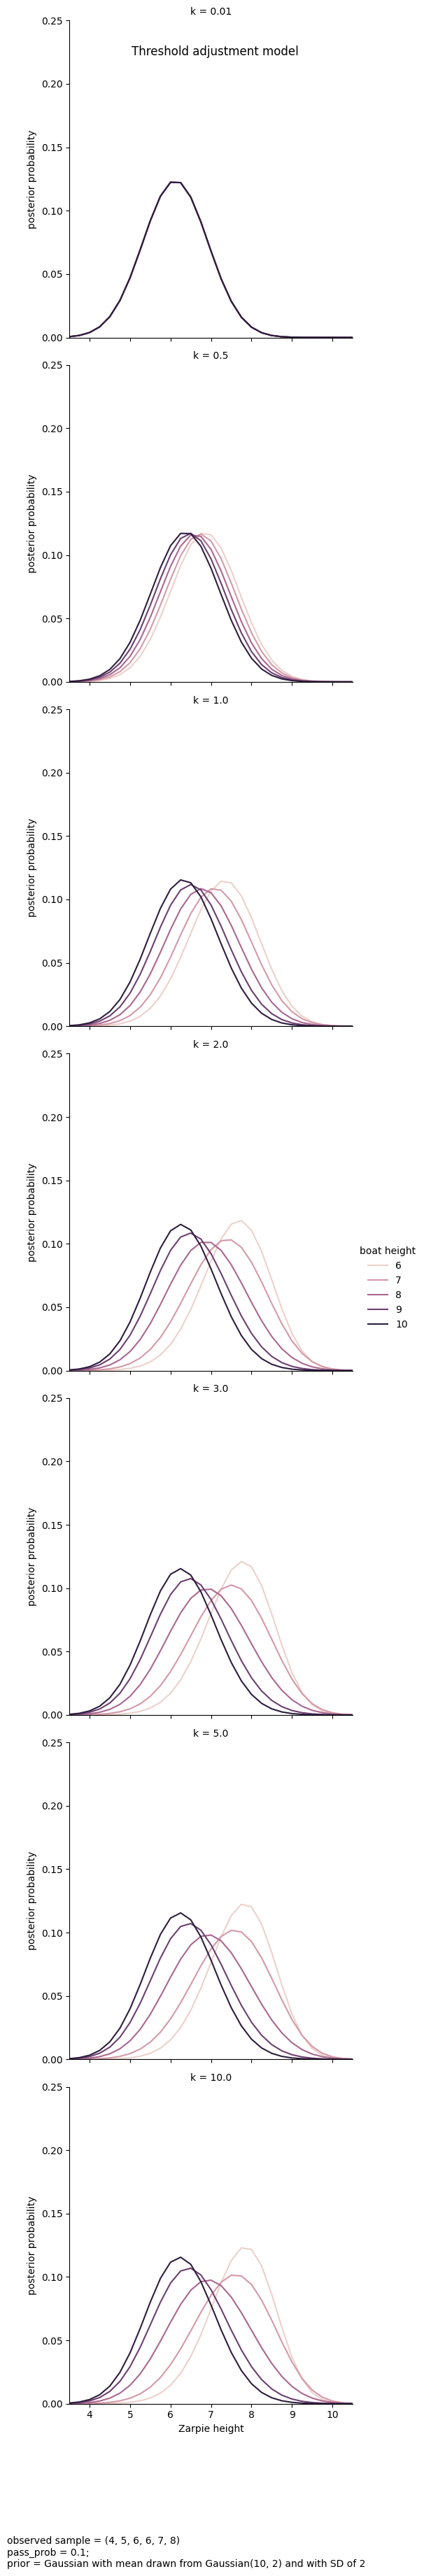

In [6]:
g = sns.relplot(data = threshold_adjustment_res_df,
                 x = "value",
                 y = "prob",
                 hue = "boat_height",
                 row = "k",
                 kind = "line") 
g._legend.set_title("boat height")
plt.figtext(x = 0, y = -.05,
            s = "observed sample = (4, 5, 6, 6, 7, 8) \npass_prob = 0.1; \nprior = Gaussian with mean drawn from Gaussian(10, 2) and with SD of 2")
g.set_ylabels("posterior probability")
plt.ylim(0, 0.25)
g.set_xlabels("Zarpie height")
plt.xlim(3.5, 10.5)
   
plt.suptitle("Threshold adjustment model")
# plt.rcParams['text.usetex'] = True
# plt.suptitle("f(z_i|t, \epsilon)=\epsilon + \frac{1-\epsilon}{1+e^{-k(t-z_i)}}")
     
plt.savefig("figs/adjustment_model_posterior_k.png", bbox_inches = "tight")
plt.show(g)


## Model predictions in study 1a

Study design
* Fixed weak prior: 10 (human adults at height 10)
* Parametrically vary boat height: 6-10
* Fixed logistic filter: relatively high k (slightly taller animal can stoop)
* Fixed filter pass-through rate: 0.1 (1 out of 10 taller animals board by stooping)
* Fixed observed sample: (4, 5, 6, 6, 7, 8) 

In [6]:
boat_heights = [6, 7, 8, 9, 10]
zarpie_heights = (4, 5, 6, 6, 7, 8) 

threshold_adjustment_res_list = []

# participants randomly assigned to one of these boat heights
for boat_height in boat_heights: 
    # run the model
    threshold_adjustment_res = threshold_adjustment_model(
        boat_height = boat_height, 
        pop_mean_prior_mean = 10, # set by human height
        zarpie_heights = zarpie_heights,
        )
    # record inferred probability on each height value
    for val, prob in threshold_adjustment_res.items():
        threshold_adjustment_res_list.append(dict(
            boat_height = boat_height,
            value = val,
            prob = prob
        ))
        
threshold_adjustment_res_df = pd.DataFrame(threshold_adjustment_res_list)

In [49]:
threshold_adjustment_res_df

,boat_height,value,prob
0,6,10.00,1.038583e-06
1,6,9.75,4.435907e-06
2,6,10.25,2.208508e-07
3,6,9.50,1.720770e-05
4,6,10.50,4.265363e-08
...,...,...,...
675,10,-9.00,6.385207e-78
676,10,-9.25,1.814898e-80
677,10,-9.50,4.685203e-83
678,10,-9.75,1.098510e-85


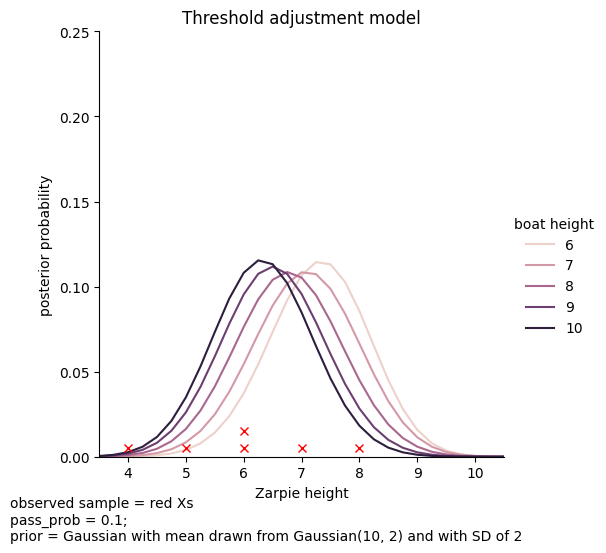

In [7]:
g = sns.relplot(data = threshold_adjustment_res_df,
                 x = "value",
                 y = "prob",
                 hue = "boat_height",
                 kind = "line") 
g._legend.set_title("boat height")
plt.title("Threshold adjustment model")
# plt.suptitle("observed sample: " + ', '.join(map(str, zarpie_heights)))
plt.figtext(x = 0, y = -.05,
            s = "observed sample = red Xs \npass_prob = 0.1; \nprior = Gaussian with mean drawn from Gaussian(10, 2) and with SD of 2")
g.set_ylabels("posterior probability")
plt.ylim(0, 0.25)
g.set_xlabels("Zarpie height")
plt.xlim(3.5, 10.5)

# add observed data
zh_counts = pd.Series(zarpie_heights).value_counts()
for v, c in zh_counts.items():
    for ci in range(c):
        g.ax.plot(v, .005+.01*ci, 'rx')
        
# # circle x-axis labels that are DV options
# labels_to_circle = [4, 6, 8]
# for label in labels_to_circle:
#     x_pos = threshold_adjustment_res_df["value"].index(label)
#     bbox_props = dict(boxstyle = "circle,pad=0.3", fc = "white", ec = "black")
#     ax.text(x_pos, 0, label, 
#             ha = "center", va = "center", 
#             bbox = bbox_props, 
#             transform = ax.get_xaxis_transform())

plt.savefig("figs/adjustment_model_posterior_1a.png", bbox_inches = "tight")
plt.show(g)


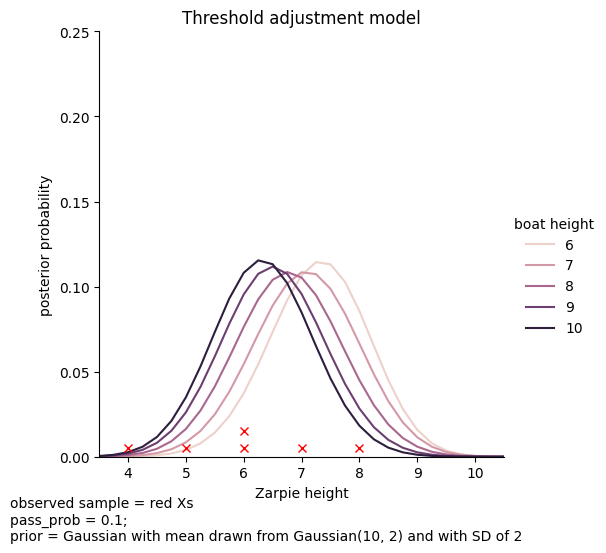

In [56]:
g = sns.relplot(data = threshold_adjustment_res_df,
                 x = "value",
                 y = "prob",
                 hue = "boat_height",
                 kind = "line") 
g._legend.set_title("boat height")
plt.title("Threshold adjustment model")
# plt.suptitle("observed sample: " + ', '.join(map(str, zarpie_heights)))
plt.figtext(x = 0, y = -.05,
            s = "observed sample = red Xs \npass_prob = 0.1; \nprior = Gaussian with mean drawn from Gaussian(10, 2) and with SD of 2")
g.set_ylabels("posterior probability")
plt.ylim(0, 0.25)
g.set_xlabels("Zarpie height")
plt.xlim(3.5, 10.5)

# add observed data
zh_counts = pd.Series(zarpie_heights).value_counts()
for v, c in zh_counts.items():
    for ci in range(c):
        g.ax.plot(v, .005+.01*ci, 'rx')
        
# # circle x-axis labels that are DV options
# labels_to_circle = [4, 6, 8]
# for label in labels_to_circle:
#     x_pos = threshold_adjustment_res_df["value"].index(label)
#     bbox_props = dict(boxstyle = "circle,pad=0.3", fc = "white", ec = "black")
#     ax.text(x_pos, 0, label, 
#             ha = "center", va = "center", 
#             bbox = bbox_props, 
#             transform = ax.get_xaxis_transform())

plt.savefig("figs/adjustment_model_posterior_1a.png", bbox_inches = "tight")
plt.show(g)


# Simple inference model
This model infers a population property (e.g., Zarpie mean height) from three things:
1. an observed sample (e.g., observed Zarpies)
2. **a model of selection that allows full observation (i.e., no bias)**
3. a prior on what the population is like (e.g., normal distribution with uncertainty over the mean height). 

In [8]:
# prior on Zarpie height distribution
# = a normal distribution, limited to range mean-20 to mean+20, SD = 2
@keep_deterministic
def discretized_gaussian(mean, sd, support=None):
    if support is None:
        support = list(np.arange(-20+mean, 20+mean, step=.25)) # step needs to be 1, .5, or .25
    return Categorical.from_continuous(
        Gaussian(mean, sd),
        support=support # restrict range to make inference easier
    )

# boat boarding model where everyone boards
@infer
def boat_boarding_model_simple(boat_height, pop_mean, pass_prob = .1):
    zarpie_height = discretized_gaussian(pop_mean, 2).sample()
    condition(1) # **everyone boards** --> this is also equivalent to setting pass_prob = 1, or boat height to infinity
    return zarpie_height

# infer population mean
# takes in: boat height, observed Zarpie heights
# assume: prior as Gaussian with mean drawn from (10, 5), pass-through probability .1
@infer
def simple_inference_model(boat_height, zarpie_heights, pop_mean_prior_mean = 10, pop_mean_prior_sd = 5, pass_prob = .1):
    pop_mean = discretized_gaussian(pop_mean_prior_mean, pop_mean_prior_sd).sample() 
    dist = boat_boarding_model_simple(boat_height = boat_height, pop_mean = pop_mean, pass_prob = pass_prob)
    [dist.observe(zarpie_height) for zarpie_height in zarpie_heights]
    return pop_mean

## Exploring the model

In [9]:
simple_inference_ev_list = []

for boat_height in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for zarpie_height_mode in [3, 4, 5, 6, 7]: # parameterize mode Zarpie's height
        for pass_prob in [0.1, 0.2, 0.3, 0.4, 0.5]:
            # run the model
            simple_inference_res = simple_inference_model(
                boat_height = boat_height, 
                zarpie_heights = (zarpie_height_mode - 2, # observed sample
                                zarpie_height_mode - 1,
                                zarpie_height_mode,
                                zarpie_height_mode, 
                                zarpie_height_mode + 1,
                                zarpie_height_mode + 2), 
                pass_prob = pass_prob
                )
            # record the expected value
            simple_inference_ev_list.append(
                {
                "boat_height": boat_height,
                "zarpie_height_mode": zarpie_height_mode,
                "pass_prob": pass_prob,
                "expected_value": simple_inference_res.expected_value()
                })

# convert to df
simple_inference_ev_df = pd.DataFrame(simple_inference_ev_list)

KeyboardInterrupt: 

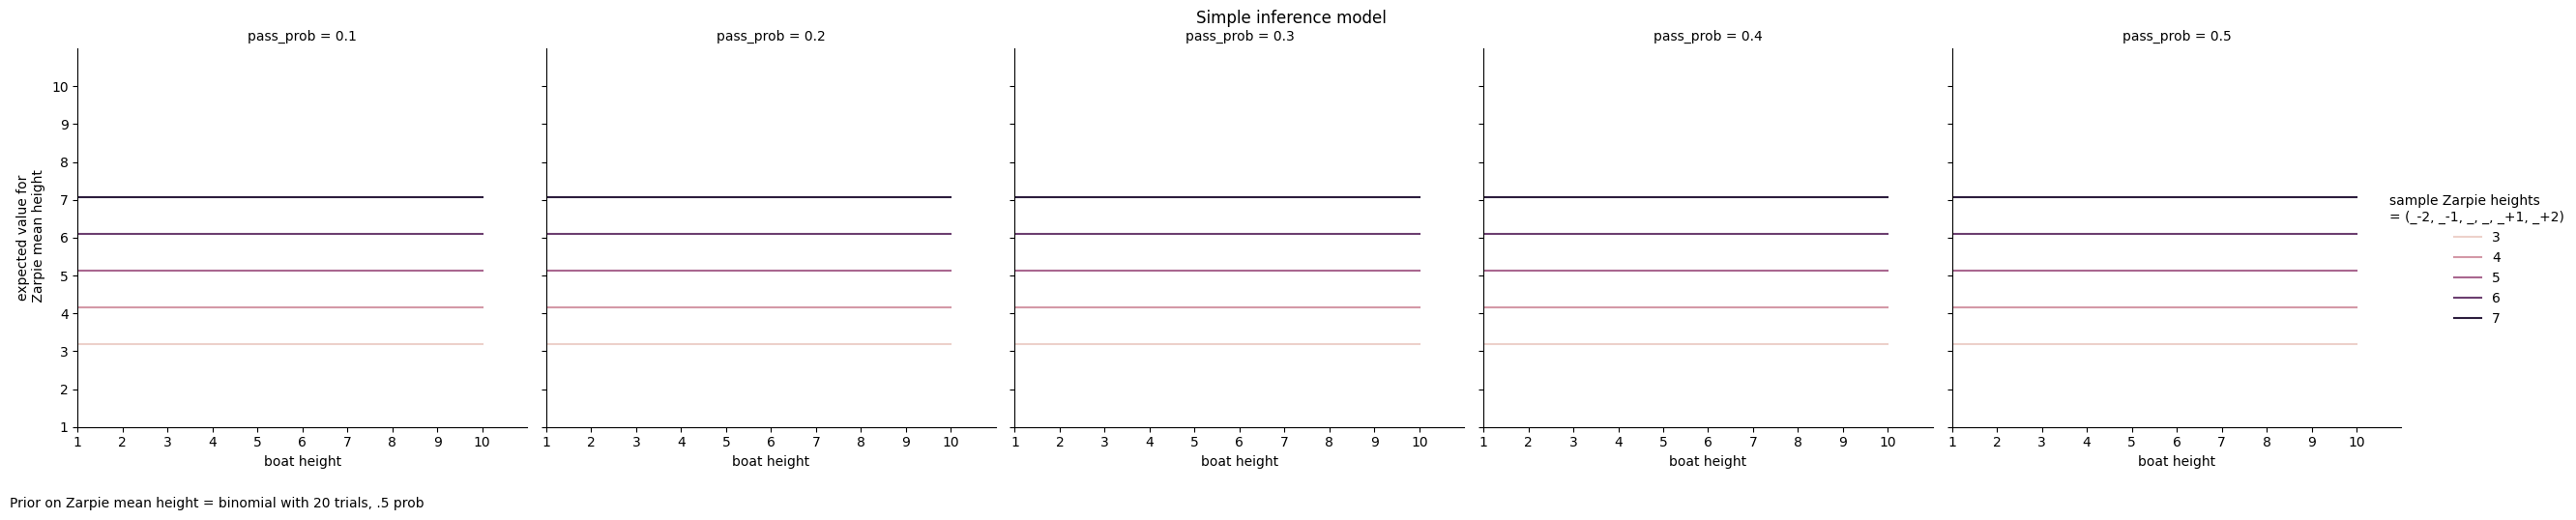

In [29]:
g = sns.relplot(data = simple_inference_ev_df,
                 x = "boat_height",
                 y = "expected_value",
                 hue = "zarpie_height_mode",
                 col = "pass_prob",
                 kind = "line")
g._legend.set_title("sample Zarpie heights \n= (_-2, _-1, _, _, _+1, _+2)")
g.set_ylabels("expected value for\n Zarpie mean height")
plt.ylim(1, 10+1)
plt.yticks(ticks = list(range(1, 10+1)))
g.set_xlabels("boat height")
plt.xlim(1, 10+1)
plt.xticks(ticks = list(range(1, 10+1)))
g.figure.suptitle("Simple inference model")
g.figure.subplots_adjust(top=0.9)
plt.figtext(x = 0, y = -.05,
            s = "Prior on Zarpie mean height = binomial with 20 trials, .5 prob")

plt.savefig("figs/simple_model_ev_passprob.png", bbox_inches = "tight")
plt.show(g)

* The simple model is **indifferent to boat height** and **to pass-through probability**. 

## Model predictions in study 1a

Study design
* Fixed weak prior for taller: see human adults at height 10
* Parametrically vary boat height: 6-10
* Fixed pass-through rate: 0.1
* Fixed observed sample: (4, 5, 6, 6, 7, 8)

In [10]:
boat_heights = [6, 7, 8, 9, 10]
zarpie_heights = (4, 5, 6, 6, 7, 8) 

simple_inference_res_list = []

# participants randomly assigned to one of these boat heights
for boat_height in boat_heights: 
    # run the model
    simple_inference_res = simple_inference_model(
        boat_height = boat_height, 
        pop_mean_prior_mean = 10, # set by human height
        zarpie_heights = zarpie_heights,
        )
    # record inferred probability on each height value
    for val, prob in simple_inference_res.items(): 
        simple_inference_res_list.append(dict(
            boat_height = boat_height,
            value = val,
            prob = prob
        ))
        
simple_inference_res_df = pd.DataFrame(simple_inference_res_list)

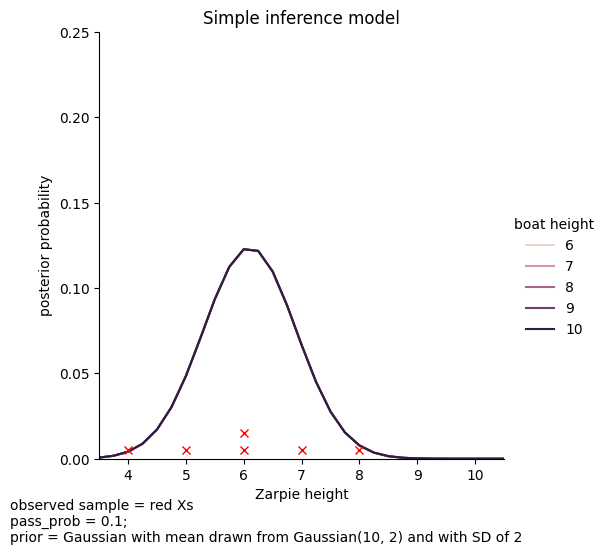

In [12]:
g = sns.relplot(data = simple_inference_res_df,
                 x = "value",
                 y = "prob",
                 hue = "boat_height",
                 kind = "line") 
g._legend.set_title("boat height")
plt.title("Simple inference model")
# plt.suptitle("observed sample: " + ', '.join(map(str, zarpie_heights)))
plt.figtext(x = 0, y = -.05,
            s = "observed sample = red Xs \npass_prob = 0.1; \nprior = Gaussian with mean drawn from Gaussian(10, 2) and with SD of 2")
g.set_ylabels("posterior probability")
plt.ylim(0, 0.25)
g.set_xlabels("Zarpie height")
plt.xlim(3.5, 10.5)
# add observed data
zh_counts = pd.Series(zarpie_heights).value_counts()
for v, c in zh_counts.items():
    for ci in range(c):
        g.ax.plot(v, .005+.01*ci, 'rx')

plt.savefig("figs/simple_model_posterior_1a.png", bbox_inches = "tight")
plt.show(g)